PCA

conda create -n pca --> 
conda activate pca

In [4]:
%pip install torch
%pip install pandas
%pip install matplotlib
%pip install numpy

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [5]:
# Temporary fix to kernel not responding
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

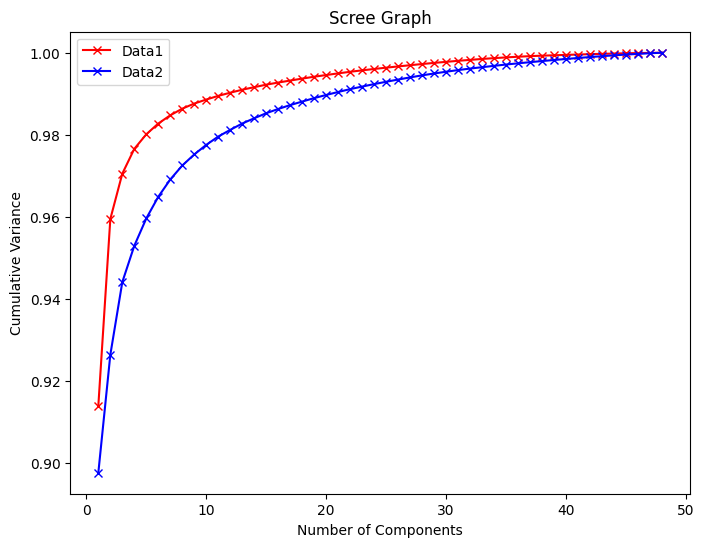

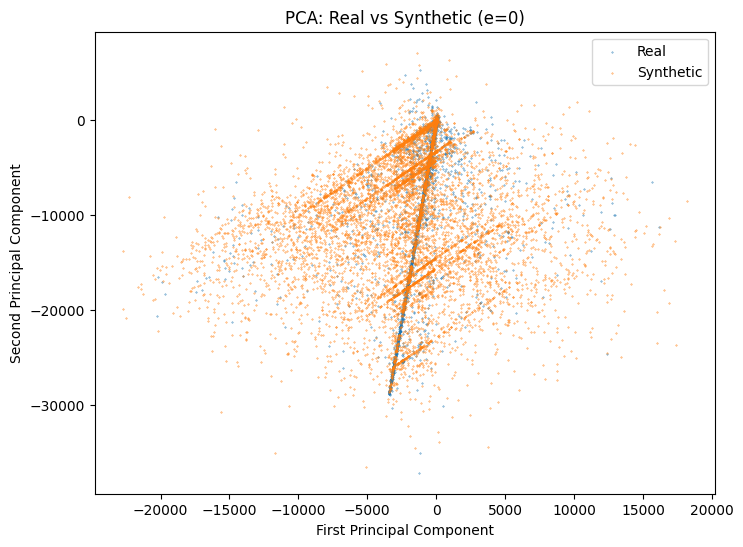

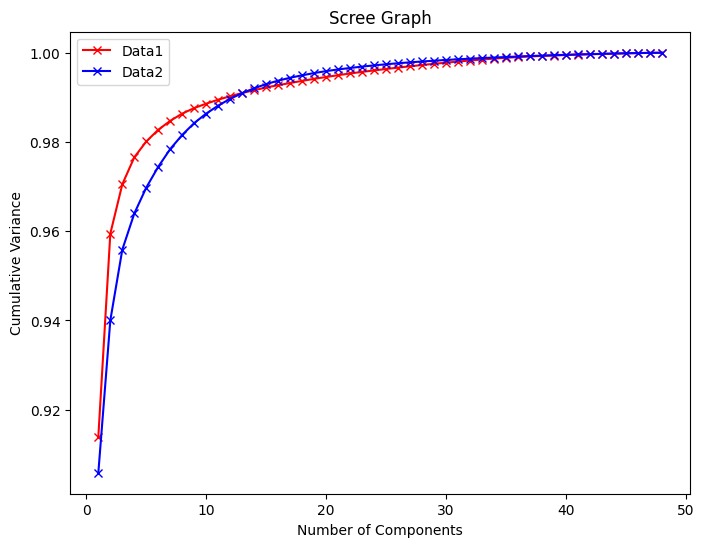

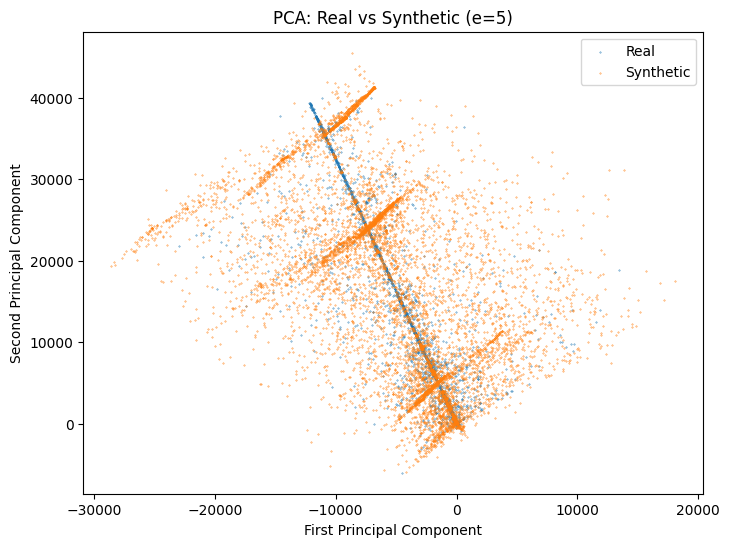

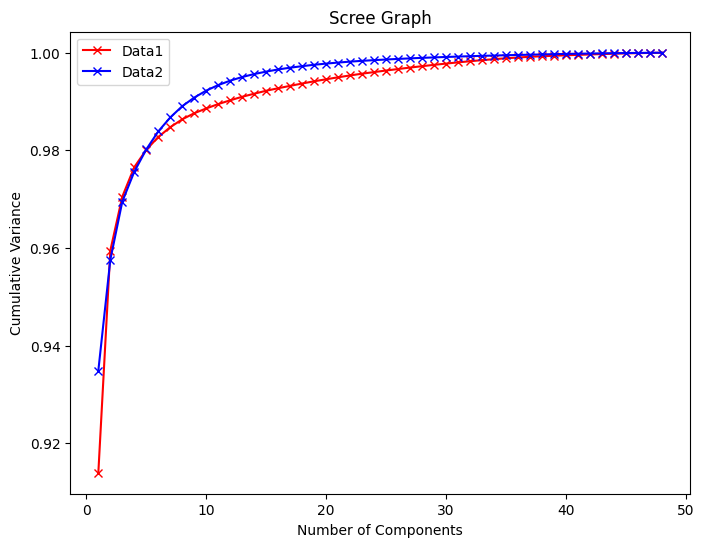

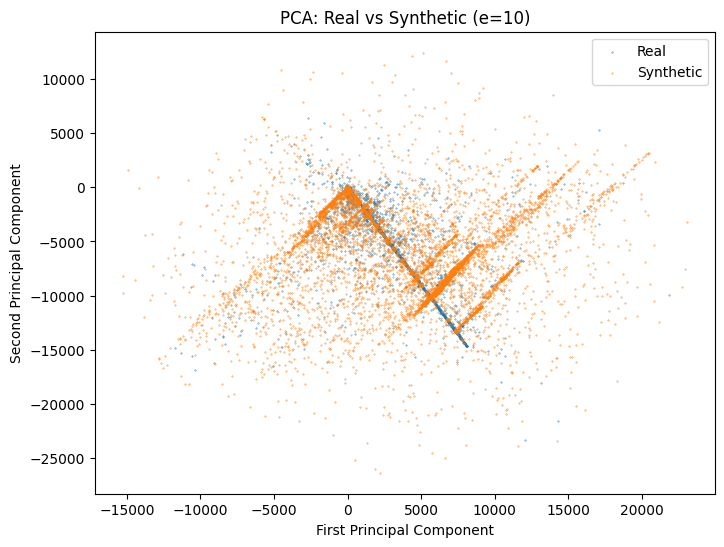

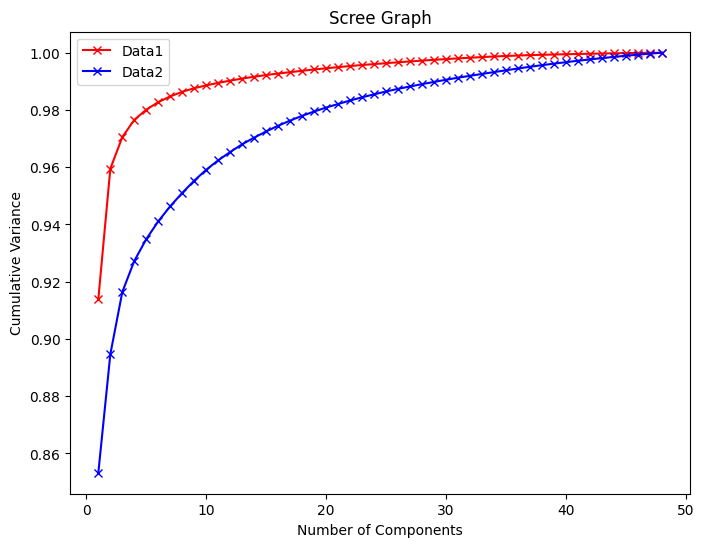

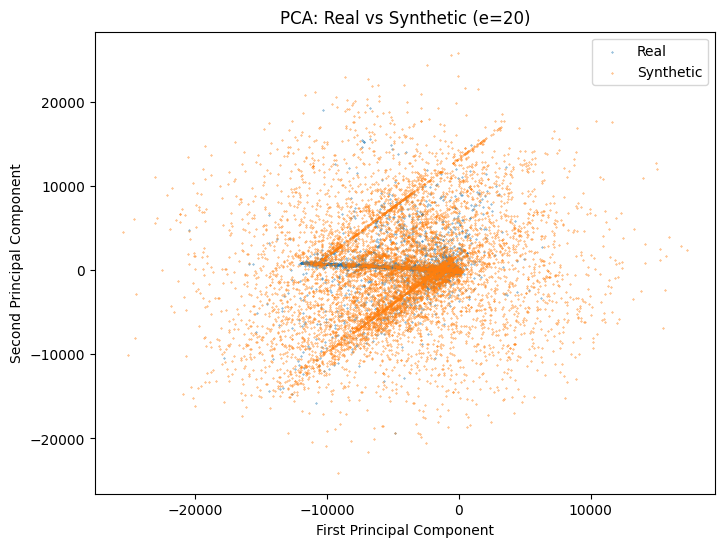

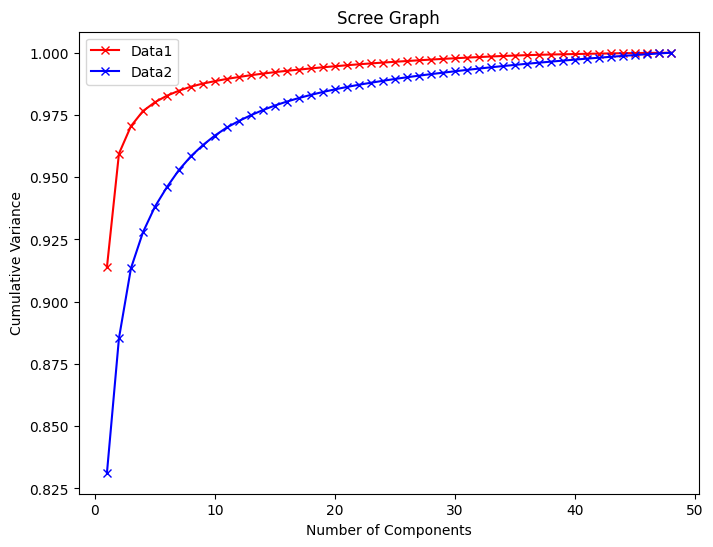

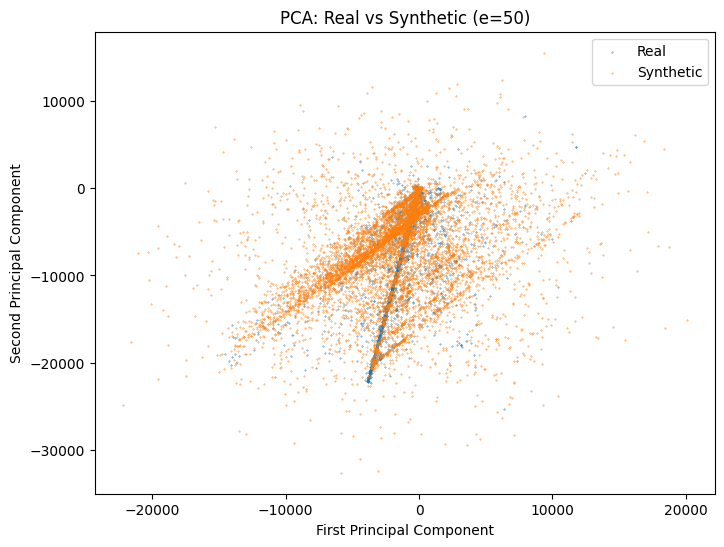

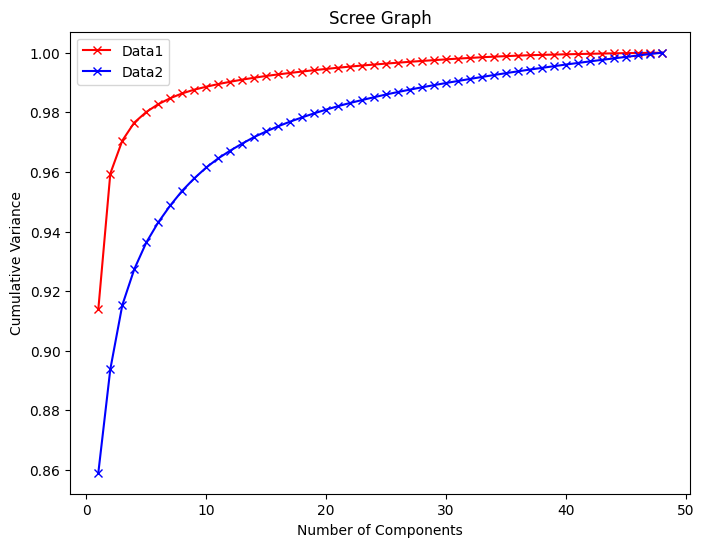

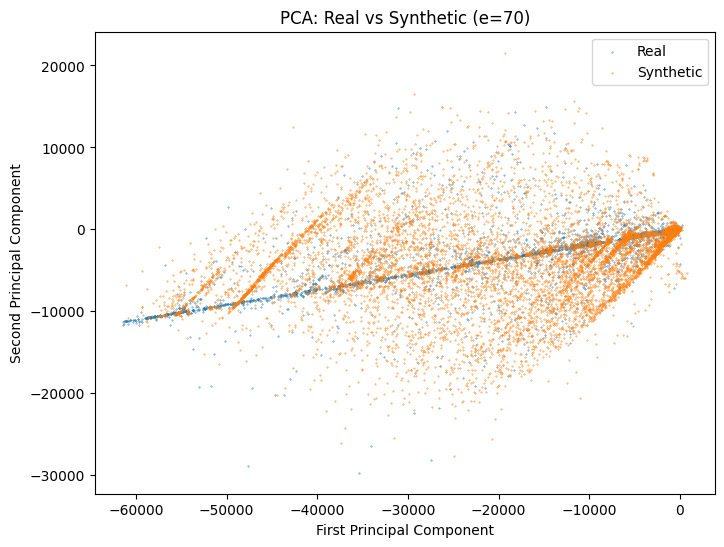

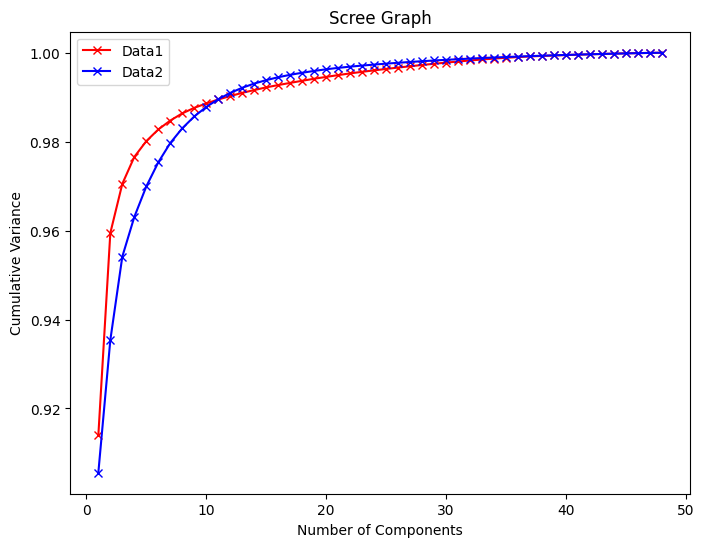

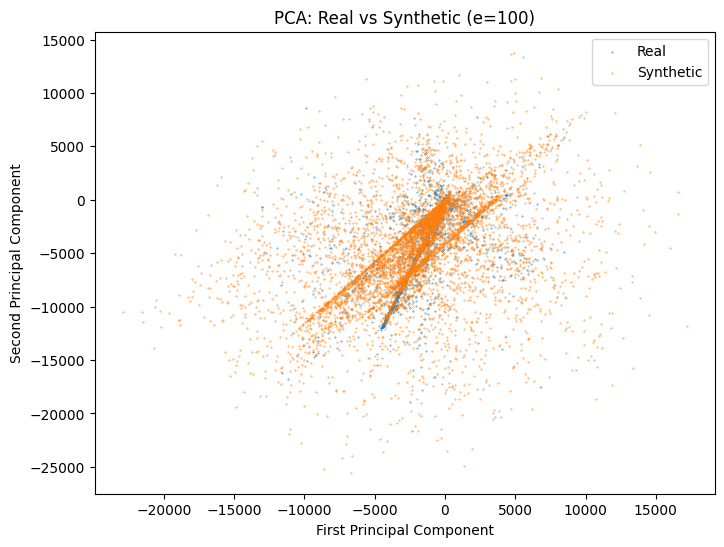

In [6]:
import torch
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from torch.utils.data import Dataset

epsilon_list = [0,5,10,20,50,70,100]
dataset1=["val", "test"]
dataset2=["gene"]
desired_variance = 0.95

# Define a custom dataset class
class TrajectoryDataset(Dataset):
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx]
    
class PCA:
    def __init__(self, epsilon):
        self.U_r = None
        self.S_r = None
        self.V_r = None
        self.tensor_data_r = None
        self.cumulative_variance_explained_r = None
        self.num_components_needed_r = None
        self.new_coordinates_r = None
        self.dataset_nr = None

        self.U_s = None
        self.S_s = None
        self.V_s = None
        self.tensor_data_s = None
        self.cumulative_variance_explained_s = None
        self.num_components_needed_s = None
        self.new_coordinates_s = None
        self.dataset_ns = None
        
        self.data_r, self.data_s = self.load_data(epsilon)
        self.perform_svd()
        self.calculate_cumulative_variance()
        self.scree_graph()
        self.get_num_components(desired_variance)
        self.project_data(epsilon)
        self.new_coordinates_comparison(self.dataset_nr.data, self.dataset_ns.data)

    def load_data(self, epsilon):
        folder_path = f'epsilon{epsilon}/'
        file_path_t = f'../{folder_path}/test.data'
        file_path_v = f'../{folder_path}/val.data'
        file_path_s = f'../{folder_path}/gene.data'
                
        data_t = pd.read_csv(file_path_t, sep=" ", header=None)
        data_t = torch.unique(torch.Tensor(data_t.values), dim=0)
        data_t = pd.DataFrame(data_t)
        labels_t = torch.ones(len(data_t))  # Label real data with 1

        data_v = pd.read_csv(file_path_v, sep=" ", header=None)
        data_v = torch.unique(torch.Tensor(data_v.values), dim=0)
        data_v = pd.DataFrame(data_v)
        labels_v = torch.ones(len(data_v))  # Label real data with 1

        data_s = pd.read_csv(file_path_s, sep=" ", header=None)
        data_s = torch.unique(torch.Tensor(data_s.values), dim=0)
        data_s = pd.DataFrame(data_s)
        labels_s = torch.zeros(len(data_s))  # Label synthetic data with 0

        # Concatenate dataset_t and dataset_v to create dataset_r
        dataset_r = TrajectoryDataset(pd.concat([data_t, data_v]).values, torch.cat([labels_t, labels_v]))
        dataset_s = TrajectoryDataset(data_s.values, labels_s)
            
        # Convert the numpy array to a pandas DataFrame
        dataset_r_values = pd.DataFrame(dataset_r.data)
        # Convert the numpy array to a pandas DataFrame
        dataset_s_values = pd.DataFrame(dataset_s.data)

        return dataset_r_values, dataset_s_values
        
    def perform_svd(self):
        self.tensor_data_r = torch.Tensor(self.data_r.values)
        self.U_r, self.S_r, self.V_r = torch.linalg.svd(self.tensor_data_r)
        
        self.tensor_data_s = torch.Tensor(self.data_s.values)
        self.U_s, self.S_s, self.V_s = torch.linalg.svd(self.tensor_data_s)
            
    def display_shape(self):
        print("Shape of eigenvalues (S1):", self.S_r.shape)
        print("Shape of eigenvectors (V1):", self.V_r.shape)
        print("Shape of eigenvalues (S2):", self.S_s.shape)
        print("Shape of eigenvectors (V2):", self.V_s.shape)
    
    def calculate_cumulative_variance(self):
        variance_explained1 = (self.S_r ** 2) / torch.sum(self.S_r ** 2)
        self.cumulative_variance_explained_r = torch.cumsum(variance_explained1, dim=0)
        
        variance_explained2 = (self.S_s ** 2) / torch.sum(self.S_s ** 2)
        self.cumulative_variance_explained_s = torch.cumsum(variance_explained2, dim=0)
    
    def scree_graph(self):
        plt.figure(figsize=(8, 6))
        plt.plot(range(1, len(self.cumulative_variance_explained_r) + 1), self.cumulative_variance_explained_r, linestyle='-', marker='x', color='red', label='Data1')
        plt.plot(range(1, len(self.cumulative_variance_explained_s) + 1), self.cumulative_variance_explained_s, linestyle='-', marker='x', color='blue', label='Data2')
        plt.xlabel('Number of Components')
        plt.ylabel('Cumulative Variance')
        plt.title('Scree Graph')
        plt.legend()
        plt.show()
    
    def get_num_components(self, desired_variance):
        self.num_components_needed_r = torch.sum(self.cumulative_variance_explained_r < desired_variance) + 1
        self.num_components_needed_s = torch.sum(self.cumulative_variance_explained_s < desired_variance) + 1
        return self.num_components_needed_r.item(), self.num_components_needed_s.item()
    
    def project_data(self, epsilon):
        self.new_coordinates_r = torch.matmul(self.tensor_data_r, self.V_s[:, :self.num_components_needed_s])
        labels_nr = torch.ones(len(self.data_r))  # Label real data with 1
        self.dataset_nr = TrajectoryDataset(self.new_coordinates_r, labels_nr)
        
        self.new_coordinates_s = torch.matmul(self.tensor_data_s, self.V_s[:, :self.num_components_needed_s])
        labels_ns = torch.ones(len(self.data_s))  # Label real data with 0
        self.dataset_ns = TrajectoryDataset(self.new_coordinates_s, labels_ns)

        # Print real and synthetic data
        #print("Real data shape:", self.dataset_nr.data.shape)
        #print("Synthetic data shape:", self.dataset_ns.data.shape)      
    
    def new_coordinates_comparison(self, new_coordinates_real, new_coordinates_synthetic):
        plt.figure(figsize=(8, 6))
        plt.scatter(new_coordinates_real[:, 0], new_coordinates_real[:, 1], label='Real', s=0.1)
        plt.scatter(new_coordinates_synthetic[:, 0], new_coordinates_synthetic[:, 1], label='Synthetic', s=0.1)
        plt.xlabel('First Principal Component')
        plt.ylabel('Second Principal Component')
        plt.title(f'PCA: Real vs Synthetic (e={epsilon})')
        plt.legend()
        plt.show()

# Perform PCA for each epsilon combination
for epsilon in epsilon_list:
            pca = PCA(epsilon)
